The goals / steps of this project are the following:

Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
Apply a distortion correction to raw images.
Use color transforms, gradients, etc., to create a thresholded binary image.
Apply a perspective transform to rectify binary image (“birds-eye view”).
Detect lane pixels and fit to find the lane boundary.
Determine the curvature of the lane and vehicle position with respect to center.
Warp the detected lane boundaries back onto the original image.
Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [4]:
import numpy as np
import cv2
import glob
# import matplotlib
# matplotlib.use('Qt4Agg')
import matplotlib.pyplot as plt
# %matplotlib qt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
nx = 9
ny = 6
objp = np.zeros((ny*nx, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')
print(images)
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

['./camera_cal\\calibration1.jpg', './camera_cal\\calibration10.jpg', './camera_cal\\calibration11.jpg', './camera_cal\\calibration12.jpg', './camera_cal\\calibration13.jpg', './camera_cal\\calibration14.jpg', './camera_cal\\calibration15.jpg', './camera_cal\\calibration16.jpg', './camera_cal\\calibration17.jpg', './camera_cal\\calibration18.jpg', './camera_cal\\calibration19.jpg', './camera_cal\\calibration2.jpg', './camera_cal\\calibration20.jpg', './camera_cal\\calibration3.jpg', './camera_cal\\calibration4.jpg', './camera_cal\\calibration5.jpg', './camera_cal\\calibration6.jpg', './camera_cal\\calibration7.jpg', './camera_cal\\calibration8.jpg', './camera_cal\\calibration9.jpg']


In [3]:
plt.get_backend()

'module://ipykernel.pylab.backend_inline'

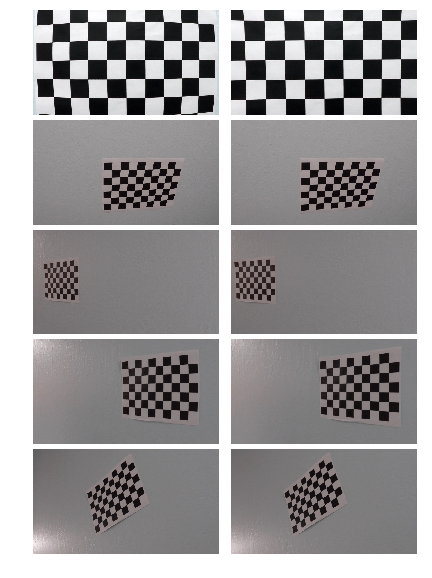

In [5]:
import os
import matplotlib.gridspec as gridspec
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
fig = plt.figure(figsize=(7,10))
i=0
gs1 = gridspec.GridSpec(5, 2)
gs1.update(wspace=0.025, hspace=0.05)
for fname in images:
    img = cv2.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    # plt.subplot()
    # cv2.imshow('img',dst)
    # cv2.waitKey(1000)
    if i < 10:
        plt.subplot(gs1[i])
        plt.imshow(img)
        plt.axis('off')
        plt.subplot(gs1[i+1])
        plt.imshow(dst)
        plt.axis('off')
        i+=2
plt.savefig('./output_images/undistorted_subplot')
plt.show()
for fname in images:
   img = cv2.imread(fname)
   dst = cv2.undistort(img, mtx, dist, None, mtx)
   # print('./output_images/undistorted_{0}'.format(os.path.basename(fname)))
   cv2.imwrite('./output_images/undistorted_{0}'.format(os.path.basename(fname)),dst)

cv2.destroyAllWindows()

In [ ]:
if len(images) != len(imgpoints):
    raise RuntimeError("I have {0} images but found {1} imgpoints - check your images in first cell")
offset = 50
img_size = gray.shape[::-1]
for i, fname in enumerate(images):
    # corners matching current image
    corners = imgpoints[i]
    src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
    dst = np.float32([[offset, offset], 
                      [img_size[0]-offset, offset], 
                      [img_size[0]-offset, img_size[1]-offset], 
                      [offset, img_size[1]-offset]
                      ])

In [42]:
undistorted_images = glob.glob('./output_images/undistorted_calibration*.jpg')
offset = 100
img_size = gray.shape[::-1]  # assuming that all images have the same dimensions
for fname in undistorted_images:
    undist = cv2.imread(fname)
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret is True:

        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        dst = np.float32([[offset, offset],
                          [img_size[0]-offset, offset],
                          [img_size[0]-offset, img_size[1]-offset],
                          [offset, img_size[1]-offset]
                          ])
        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(undist, M, img_size)
        cv2.imshow('warped image', warped)
        cv2.waitKey(500)
    else:
        print('WARNING: some corners lost during undistortion for image {0}'.format(os.path.basename(fname)))
    # If found, add object points, image points
    # if ret == True:
    #     # objpoints.append(objp)
    #     # imgpoints.append(corners)
    # 
    #     # Draw and display the corners
    #     
    #     img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
    #     cv2.imshow('img',img)
    #     cv2.waitKey(500)

cv2.destroyAllWindows()

In [ ]:
images = glob.glob('./output_images/undistorted_calibration*.jpg')

for fname in undistorted_images:
    img = cv2.imread(fname)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

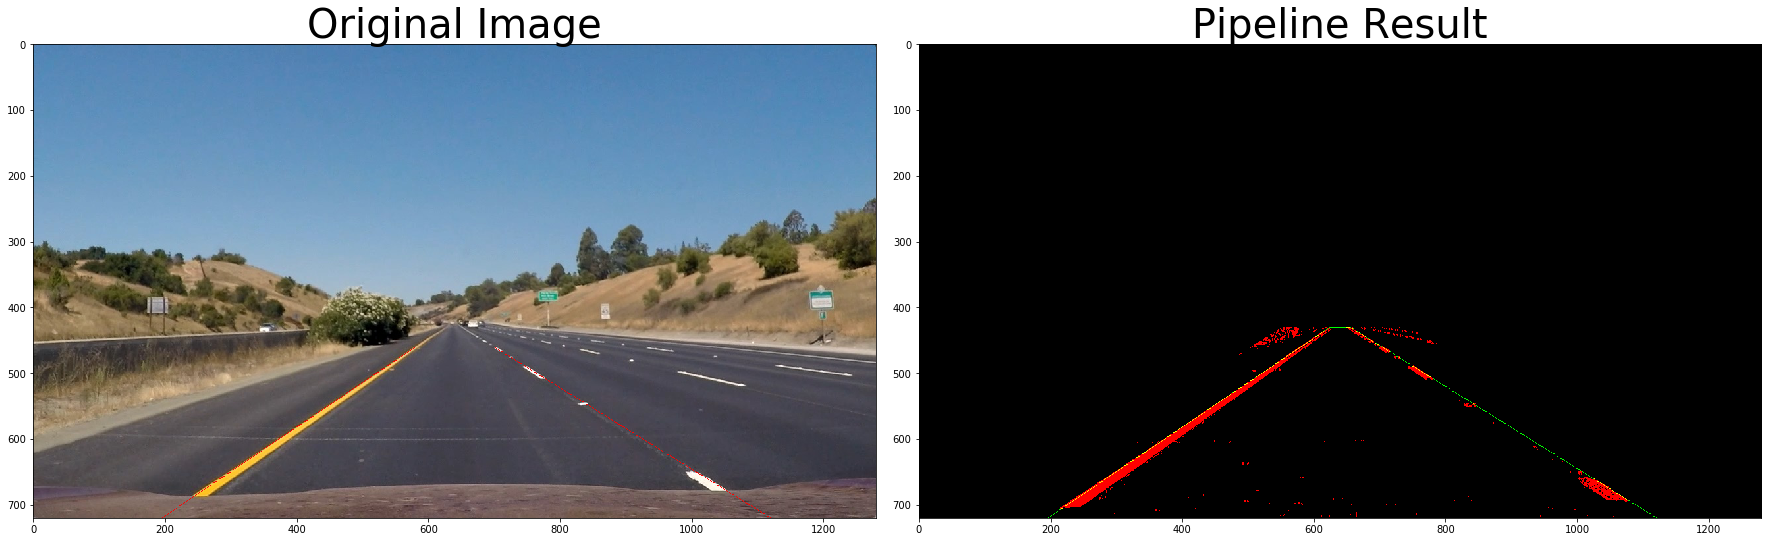

In [37]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (1,) * channel_count
    else:
        ignore_mask_color = 1
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(undist, cv2.COLOR_BGR2HLS).astype(np.float)
    # hsv = cv2.cvtColor(undist, cv2.COLOR_BGR2HSV).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # np.dstack(np.zeros_like(s_binary), sxbinary, s_binary)
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    third_layer = np.zeros_like(sxbinary)
    third_layer = (sxbinary + s_binary)
    third_layer[(third_layer >= 1)] = 1
    third_layer = region_of_interest(third_layer, 
            [np.array([[100, image.shape[0]], [550, 430], [750, 430], [image.shape[1]-100, image.shape[0]]])])
    sxbinary = np.zeros_like(sxbinary)
    s_binary = np.zeros_like(sxbinary)
    cv2.polylines(sxbinary, 
                  [np.array([[195, image.shape[0]], [623, 430], [655, 430], [image.shape[1]-160, image.shape[0]]])],
                  True,
                  1
                  )
    color_binary = np.dstack((third_layer, sxbinary, s_binary))
    return color_binary
    
images = glob.glob('./test_images/straight*')
for fname in images:
    image = cv2.imread(fname)
    result = pipeline(image, (190, 255), (20, 150))
    # fig = plt.figure()
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    
    # cv2.polylines(image, 
    #               [np.array([[195, image.shape[0]], [623, 430], [655, 430], [image.shape[1]-160, image.shape[0]]])],
    #               True,
    #               (0, 0, 255)
    #               )    
    cv2.polylines(image, 
                  [np.array([[195, image.shape[0]], [580, 460], [700, 460], [image.shape[1]-160, image.shape[0]]])],
                  True,
                  (0, 0, 255)
                  )
    ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=40)
    
    ax2.imshow(result)
    ax2.set_title('Pipeline Result', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.savefig('./output_images/pipeline_undist_{0}'.format(os.path.basename(fname)))

In [49]:
offset = 300
img_size = gray.shape[::-1]
print(img_size)
src = np.float32([[195, image.shape[0]], 
                [623, 430], 
                [655, 430], 
                [image.shape[1]-160, image.shape[0]]
                ])
src = np.float32([[580, 460], [700, 460], [1120, 720], [195, 720]])
dst = np.float32([
                  
                  [offset, 0],
                  [image.shape[1]-offset, 0],
                  [image.shape[1]-offset, image.shape[0]],
                  [offset, image.shape[0]],
                  ])
dst = np.float32([[300, 0],
                  [960, 0],
                  [960, 700],
                  [300, 700],
                ])
print(dst)
M = cv2.getPerspectiveTransform(src, dst)
print(M)
warped = cv2.warpPerspective(image, M, img_size)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted and warped', fontsize=40)
plt.savefig('./output_images/warped.jpg')
cv2.imwrite('./output_images/warped_cv2.jpg',warped)

(1280, 720)
[[ 300.    0.]
 [ 960.    0.]
 [ 960.  700.]
 [ 300.  700.]]
[[ -5.06045414e-01  -1.46151578e+00   9.38201121e+02]
 [ -2.44249065e-15  -1.90946623e+00   8.78354468e+02]
 [ -3.03576608e-18  -2.37393099e-03   1.00000000e+00]]


True